In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from IPython.display import Audio, display
import sounddevice as sd


In [3]:
# %% Parâmetros
duracao = 8  # duração em segundos
fs = 44100  # taxa de amostragem padrão
nBits = 16  # bits por amostra (usado implicitamente pelo sounddevice para tipo de dado)
nCanais = 1  # MONO

In [4]:
# %% Gravação do áudio mono
print('Iniciando gravação mono... Fale agora.')
x_mono = sd.rec(int(duracao * fs), samplerate=fs, channels=nCanais, dtype='float64')
sd.wait()  # Espera a gravação terminar
print('Gravação encerrada.')

Iniciando gravação mono... Fale agora.
Gravação encerrada.


In [5]:
# Garante que 'x_mono' seja um array 1D caso sd.rec retorne (N,1)
if x_mono.ndim > 1:
    x_mono = x_mono.flatten()

In [6]:
# %% Salva o áudio original (sem ruído)
output_filename_original = 'audio_original_gravado.wav'
write(output_filename_original, fs, (x_mono * (2**15 - 1)).astype(np.int16))
print(f'Arquivo do áudio original salvo: {output_filename_original}')

Arquivo do áudio original salvo: audio_original_gravado.wav


In [30]:
# Se quiser carregar um audio preexistente
from scipy.io.wavfile import read
import os

output_filename_original = 'audio_original_gravado.wav'

if os.path.exists(output_filename_original):
    # print(f'Arquivo "{output_filename_original}" encontrado. Carregando áudio...') # Comentado para ser mais conciso
    samplerate_read, x_mono = read(output_filename_original)
    if x_mono.dtype == np.int16:
        x_mono = x_mono.astype(np.float64) / (2**15)
    elif x_mono.dtype == np.int32:
        x_mono = x_mono.astype(np.float64) / (2**31)
    if x_mono.ndim > 1:
        if x_mono.shape[1] > 1:
            x_mono = x_mono[:, 0]
        x_mono = x_mono.flatten()
    # print('Áudio carregado com sucesso.') # Comentado para ser mais conciso
else:
    print(f'Erro: Arquivo "{output_filename_original}" não encontrado. Por favor, grave o áudio primeiro.')
    x_mono = np.array([]) # Define x_mono como array vazio para evitar NameError em células futuras

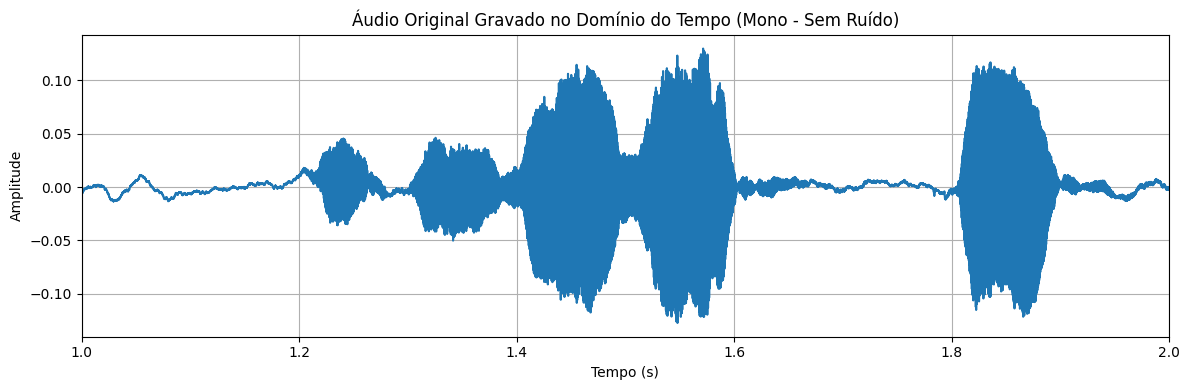

In [31]:
# Plot do sinal original (sem ruído) no domínio do tempo
plt.figure(figsize=(12, 4))
plt.plot(np.arange(x_mono.shape[0]) / fs, x_mono)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Áudio Original Gravado no Domínio do Tempo (Mono - Sem Ruído)')
plt.xlim([1, 2]) # Zoom nos primeiros 50 ms para detalhes
plt.grid(True)
plt.tight_layout()
plt.show()

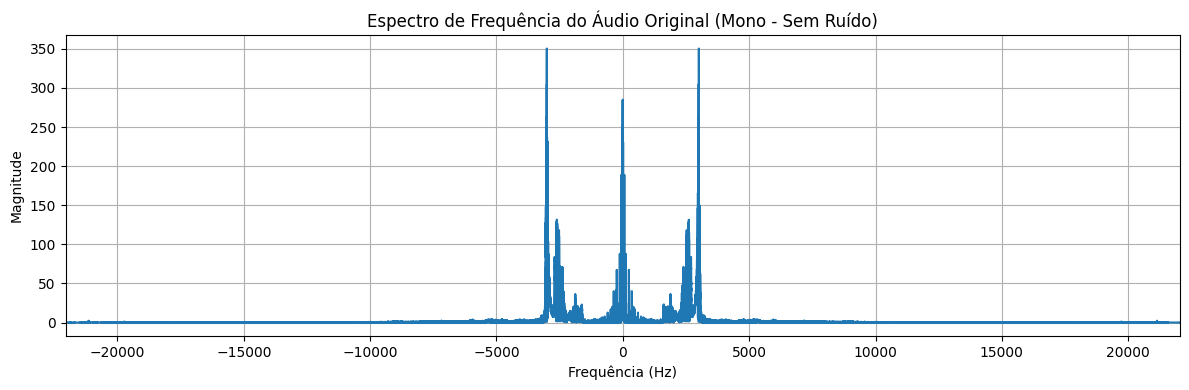

In [32]:
# Plot do sinal original (sem ruído) no domínio da frequência
N_original = x_mono.shape[0]
f_original = np.fft.fftfreq(N_original, 1/fs)
f_original_shifted = np.fft.fftshift(f_original)
X_original = np.fft.fft(x_mono)
X_original_shifted = np.fft.fftshift(X_original)


plt.figure(figsize=(12, 4))
plt.plot(f_original_shifted, np.abs(X_original_shifted))
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência do Áudio Original (Mono - Sem Ruído)')
plt.xlim([-fs / 2, fs / 2])
plt.grid(True)
plt.tight_layout()
plt.show()


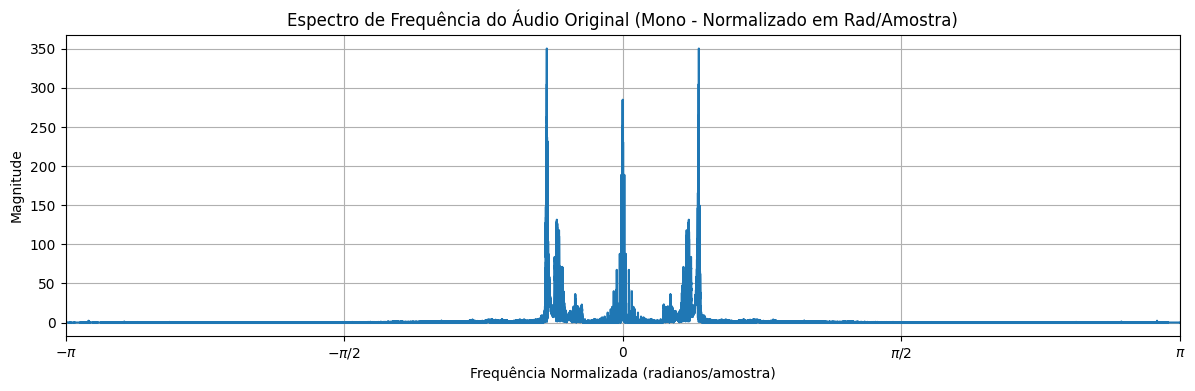

In [33]:
f_original_rad_shifted = f_original_shifted * (2 * np.pi / fs)


plt.figure(figsize=(12, 4))
plt.plot(f_original_rad_shifted, np.abs(X_original_shifted))
plt.xlabel('Frequência Normalizada (radianos/amostra)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência do Áudio Original (Mono - Normalizado em Rad/Amostra)')
plt.xlim([-np.pi, np.pi]) # Limita o eixo X de -pi a pi
plt.grid(True)
plt.tight_layout()
# Configura os rótulos do eixo X para mostrar os valores em termos de pi.
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
plt.show()

In [34]:
# Para reproduzir o áudio original (sem ruído) no Jupyter local
output_filename_original = 'audio_original_gravado.wav' # Caminho para o arquivo salvo
print('\nReproduzindo o áudio original (sem ruído):')
display(Audio(output_filename_original))


Reproduzindo o áudio original (sem ruído):


In [35]:
# %% Geração do sinal de ruído (mesmo tamanho e um canal)
t = np.arange(0, duracao, 1/fs)
# Frequências e amplitudes do ruído
f1 = 5900
f2 = 6200
a1 = 0.01
a2 = 0.01

# Sinal de ruído mono
r = a1 * np.cos(2 * np.pi * f1 * t) + a2 * np.cos(2 * np.pi * f2 * t)
#r = r / np.max(np.abs(r))  # normaliza

# Garante que 'r' tenha a mesma forma para a soma
if r.ndim > 1:
    r = r.flatten()

In [36]:
# %% Soma do áudio gravado com o ruído
# Para somar, os dois sinais precisam ter o mesmo comprimento
len_min = min(x_mono.shape[0], r.shape[0])
x_mono_cropped = x_mono[:len_min] # Usa a versão cortada para soma
r_cropped = r[:len_min]
sinal_resultante = x_mono_cropped + r_cropped

# Normalizar para evitar clipping
sinal_resultante = sinal_resultante / np.max(np.abs(sinal_resultante))

In [37]:
# %% Salva o áudio com ruído
output_filename_ruido = 'audio_com_ruido.wav'
# A função write espera os dados em um formato inteiro (por exemplo, int16 para 16 bits).
# Como nosso sinal_resultante está normalizado entre -1 e 1 (float),
# multiplicamos ele pelo valor máximo de um int16 (2**15 - 1 = 32767)
# e depois convertemos para o tipo np.int16.
write(output_filename_ruido, fs, (sinal_resultante * (2**15 - 1)).astype(np.int16))
print(f'Arquivo do áudio com ruído salvo: {output_filename_ruido}')

Arquivo do áudio com ruído salvo: audio_com_ruido.wav


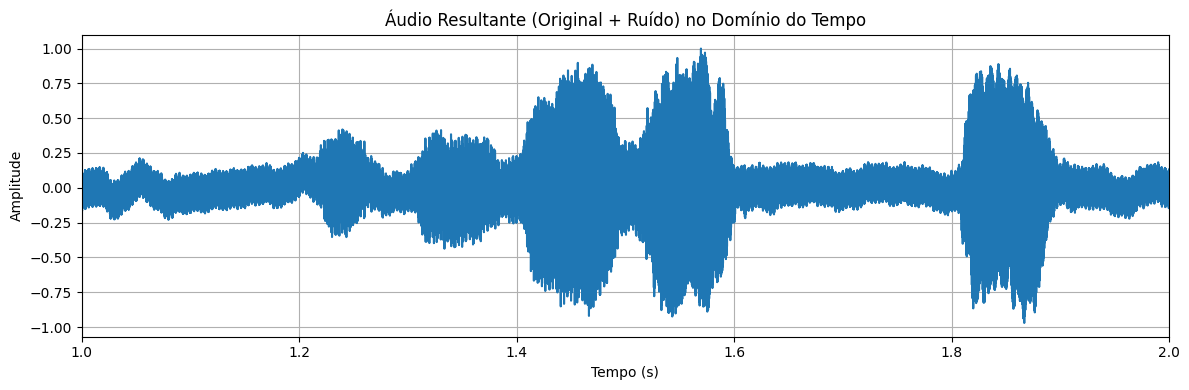

In [38]:
# Plot do sinal resultante - domínio do tempo
plt.figure(figsize=(12, 4)) # Cria a figura
plt.plot(np.arange(sinal_resultante.shape[0]) / fs, sinal_resultante) # ADICIONA O GRÁFICO
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Áudio Resultante (Original + Ruído) no Domínio do Tempo')
plt.xlim([1, 2])
plt.grid(True)
plt.tight_layout()
plt.show() # EXIBE O GRÁFICO

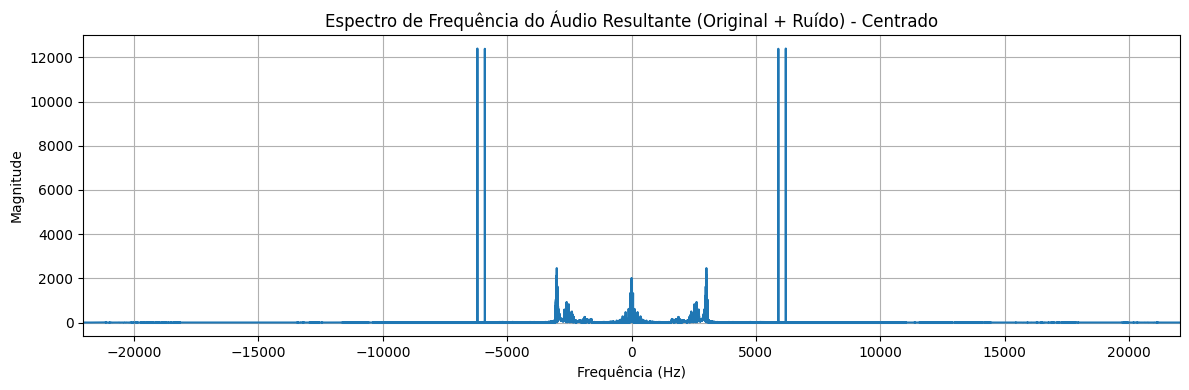

In [39]:
# %% Plot do sinal resultante - domínio da frequência (em Hertz - Completo e Centrado)
# Calcula o número de amostras do sinal resultante
N_resultante = sinal_resultante.shape[0]

# Realiza a Transformada Rápida de Fourier (FFT)
R_resultante = np.fft.fft(sinal_resultante)

# Reorganiza o espectro para ter a frequência zero no centro
R_resultante_shifted = np.fft.fftshift(R_resultante)

# Calcula as frequências correspondentes para o espectro
# np.fft.fftfreq retorna as frequências de amostragem na ordem padrão.
# Para corresponder ao fftshift, também precisamos "shiftar" as frequências.
f_resultante = np.fft.fftfreq(N_resultante, 1/fs)
f_resultante_shifted = np.fft.fftshift(f_resultante)

plt.figure(figsize=(12, 4))
# Plota o espectro completo (positivo e negativo), com 0 Hz no centro
plt.plot(f_resultante_shifted, np.abs(R_resultante_shifted))
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência do Áudio Resultante (Original + Ruído) - Centrado')
plt.xlim([-fs / 2, fs / 2]) # Limita o eixo X de -Nyquist a +Nyquist
plt.grid(True)
plt.tight_layout()
plt.show()

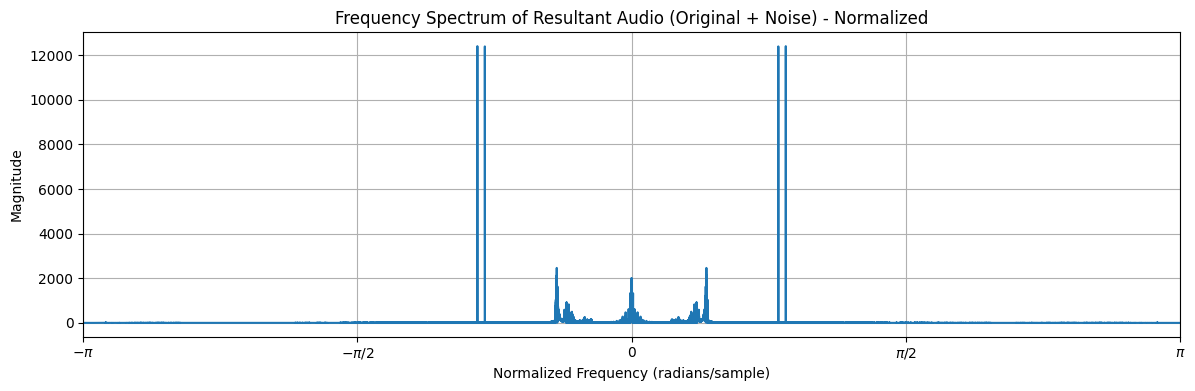

In [40]:
f_resultante_rad_shifted = f_resultante_shifted * (2 * np.pi / fs)


plt.figure(figsize=(12, 4))
plt.plot(f_resultante_rad_shifted, np.abs(R_resultante_shifted))
plt.xlabel('Normalized Frequency (radians/sample)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of Resultant Audio (Original + Noise) - Normalized')
plt.xlim([-np.pi, np.pi]) # Set X-axis limits from -pi to pi
plt.grid(True)
plt.tight_layout()
# Set X-axis ticks to show values in terms of pi.
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
plt.show()

In [41]:
# Para reproduzir o áudio modificado (com ruído) no Jupyter local
output_filename_original = 'audio_com_ruido.wav' # Caminho para o arquivo salvo
print('\nReproduzindo o áudio modificado (com ruído):')
display(Audio(output_filename_original))


Reproduzindo o áudio modificado (com ruído):
